# Approving Credit Card Prediction
## Context
Credit score cards are a common risk control method in the financial industry. It uses personal information and data submitted by credit card applicants to predict the probability of future defaults and credit card borrowings. The bank is able to decide whether to issue a credit card to the applicant. Credit scores can objectively quantify the magnitude of risk.
 
Generally speaking, credit score cards are based on historical data. Once encountering large economic fluctuations. Past models may lose their original predictive power. Logistic model is a common method for credit scoring. Because Logistic is suitable for binary classification tasks and can calculate the coefficients of each feature. In order to facilitate understanding and operation, the score card will multiply the logistic regression coefficient by a certain value (such as 100) and round it.
 
At present, with the development of machine learning algorithms. More predictive methods such as Boosting, Random Forest, and Support Vector Machines have been introduced into credit card scoring. However, these methods often do not have good transparency. It may be difficult to provide customers and regulators with a reason for rejection or acceptance.

## Task
Build a machine learning model to predict if an applicant is 'good' or 'bad' client, different from other tasks, the definition of 'good' or 'bad' is not given.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
app = pd.read_csv("https://raw.githubusercontent.com/DNR07/AppData/main/application_record.csv")
crecord = pd.read_csv("https://raw.githubusercontent.com/DNR07/CovidPredDatasets/main/credit_record.csv")

In [3]:
app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [4]:
crecord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [5]:
app['ID'].nunique() # the total rows are 438,557. This means it has duplicates

438510

In [6]:
crecord['ID'].nunique() 
# this has around 43,000 unique rows as there are repeating entries for different monthly values and status.

45985

In [7]:
len(set(crecord['ID']).intersection(set(app['ID']))) # checking to see how many records match in two datasets

36457

<AxesSubplot:>

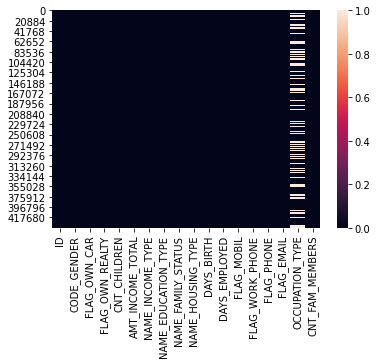

In [8]:
sns.heatmap(app.isnull()) # checking for null values. Seems like occupation_type has many

<AxesSubplot:>

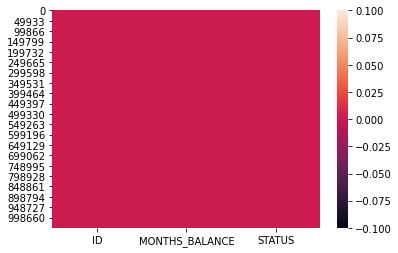

In [9]:
sns.heatmap(crecord.isnull()) # checking for null values. All good here!

In [10]:
app = app.drop_duplicates('ID', keep='last') 
# we identified that there are some duplicates in this dataset
# we will be deleting those duplicates and will keep the last entry of the ID if its repeated.

In [11]:
app.drop('OCCUPATION_TYPE', axis=1, inplace=True) 
#we identified earlier that occupation_type has many missing values
# we will drop this column

In [12]:
ot = pd.DataFrame(app.dtypes =='object').reset_index()
object_type = ot[ot[0] == True]['index']
object_type
#we are filtering the columns that have non numeric values to see if they are useful

1            CODE_GENDER
2           FLAG_OWN_CAR
3        FLAG_OWN_REALTY
6       NAME_INCOME_TYPE
7    NAME_EDUCATION_TYPE
8     NAME_FAMILY_STATUS
9      NAME_HOUSING_TYPE
Name: index, dtype: object

In [13]:
num_type = pd.DataFrame(app.dtypes != 'object').reset_index().rename(columns =  {0:'yes/no'})
num_type = num_type[num_type['yes/no'] ==True]['index']
#HAVE CREATED SEPARATE LIST FOR NUMERIC TYPE INCASE IT WILL BE NEEDED IN FURTHER ANALYSIS
# IT IS NEEDED IN FURTHER ANALYSIS

In [14]:
a = app[object_type]['CODE_GENDER'].value_counts()
b = app[object_type]['FLAG_OWN_CAR'].value_counts()
c = app[object_type]['FLAG_OWN_REALTY'].value_counts()
d = app[object_type]['NAME_INCOME_TYPE'].value_counts()
e = app[object_type]['NAME_EDUCATION_TYPE'].value_counts()
f = app[object_type]['NAME_FAMILY_STATUS'].value_counts()
g = app[object_type]['NAME_HOUSING_TYPE'].value_counts()

print( a,"\n",b,'\n', c, '\n', d, '\n', e, '\n', f, '\n', g)

#this is just to see what each column is. 
#It seems that all of them are important since there is very fine classifcation in each column.
# their effectiveness cannot be judged at this moment so we convert all of them to numeric values.

F    294412
M    144098
Name: CODE_GENDER, dtype: int64 
 N    275428
Y    163082
Name: FLAG_OWN_CAR, dtype: int64 
 Y    304043
N    134467
Name: FLAG_OWN_REALTY, dtype: int64 
 Working                 226087
Commercial associate    100739
Pensioner                75483
State servant            36184
Student                     17
Name: NAME_INCOME_TYPE, dtype: int64 
 Secondary / secondary special    301789
Higher education                 117509
Incomplete higher                 14849
Lower secondary                    4051
Academic degree                     312
Name: NAME_EDUCATION_TYPE, dtype: int64 
 Married                 299798
Single / not married     55268
Civil marriage           36524
Separated                27249
Widow                    19671
Name: NAME_FAMILY_STATUS, dtype: int64 
 House / apartment      393788
With parents            19074
Municipal apartment     14213
Rented apartment         5974
Office apartment         3922
Co-op apartment          1539
Name: NAM

In [15]:
le = LabelEncoder()
for x in app:
    if app[x].dtypes=='object':
        app[x] = le.fit_transform(app[x])
# we have transformed all the non numeric data columns into data columns
# this method applies 0,1.. classification to different value types.

In [16]:
app.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,5008804,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,1,0,0,2.0
1,5008805,1,1,1,0,427500.0,4,1,0,4,-12005,-4542,1,1,0,0,2.0
2,5008806,1,1,1,0,112500.0,4,4,1,1,-21474,-1134,1,0,0,0,2.0
3,5008808,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,1.0
4,5008809,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,1.0
5,5008810,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,1.0
6,5008811,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,1,0,1,1,1.0
7,5008812,0,0,1,0,283500.0,1,1,2,1,-22464,365243,1,0,0,0,1.0
8,5008813,0,0,1,0,283500.0,1,1,2,1,-22464,365243,1,0,0,0,1.0
9,5008814,0,0,1,0,283500.0,1,1,2,1,-22464,365243,1,0,0,0,1.0


In [17]:
app[num_type].head()
# We will look at numeric columns and see if there is anything that needs to be changed. 

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,5008804,0,427500.0,-12005,-4542,1,1,0,0,2.0
1,5008805,0,427500.0,-12005,-4542,1,1,0,0,2.0
2,5008806,0,112500.0,-21474,-1134,1,0,0,0,2.0
3,5008808,0,270000.0,-19110,-3051,1,0,1,1,1.0
4,5008809,0,270000.0,-19110,-3051,1,0,1,1,1.0


<AxesSubplot:xlabel='ID', ylabel='CNT_FAM_MEMBERS'>

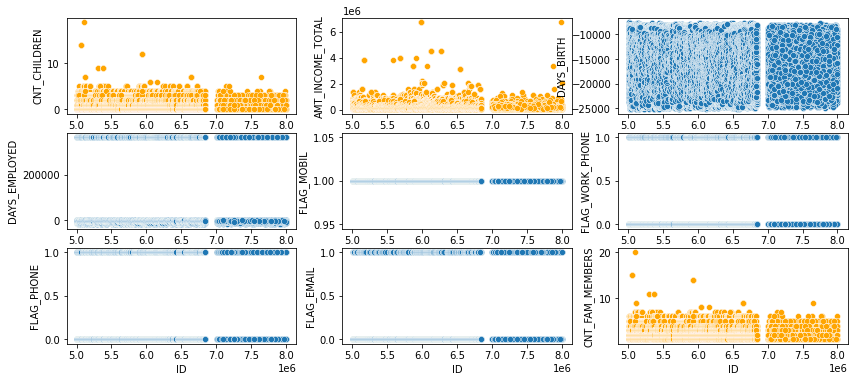

In [18]:
fig, ax= plt.subplots(nrows= 3, ncols = 3, figsize= (14,6))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=app, ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=app, ax=ax[0][1], color='orange')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=app, ax=ax[0][2])
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=app, ax=ax[1][0])
sns.scatterplot(x='ID', y='FLAG_MOBIL', data=app, ax=ax[1][1])
sns.scatterplot(x='ID', y='FLAG_WORK_PHONE', data=app, ax=ax[1][2])
sns.scatterplot(x='ID', y='FLAG_PHONE', data=app, ax=ax[2][0])
sns.scatterplot(x='ID', y='FLAG_EMAIL', data=app, ax=ax[2][1])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=app, ax=ax[2][2], color= 'orange')

There are outliers in 3 columns.

CNT_CHILDREN
AMT_INCOME_TOTAL
CNT_FAM_MEMBERS
We need to remove these outliers to make sure they do not affect our model results.
We will now remove these outliers.

In [19]:
# FOR CNT_CHILDREN COLUMN
q_hi = app['CNT_CHILDREN'].quantile(0.999)
q_low = app['CNT_CHILDREN'].quantile(0.001)
app = app[(app['CNT_CHILDREN']>q_low) & (app['CNT_CHILDREN']<q_hi)]

In [20]:
# FOR AMT_INCOME_TOTAL COLUMN
q_hi = app['AMT_INCOME_TOTAL'].quantile(0.999)
q_low = app['AMT_INCOME_TOTAL'].quantile(0.001)
app= app[(app['AMT_INCOME_TOTAL']>q_low) & (app['AMT_INCOME_TOTAL']<q_hi)]

In [21]:
#FOR CNT_FAM_MEMBERS COLUMN
q_hi = app['CNT_FAM_MEMBERS'].quantile(0.999)
q_low = app['CNT_FAM_MEMBERS'].quantile(0.001)
app= app[(app['CNT_FAM_MEMBERS']>q_low) & (app['CNT_FAM_MEMBERS']<q_hi)]

<AxesSubplot:xlabel='ID', ylabel='CNT_FAM_MEMBERS'>

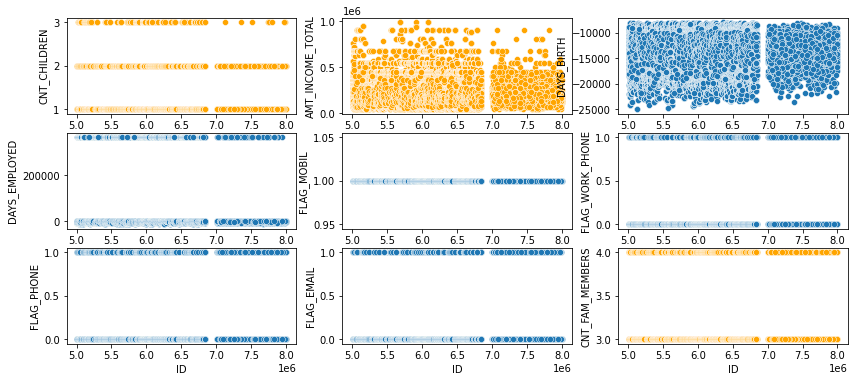

In [22]:
fig, ax= plt.subplots(nrows= 3, ncols = 3, figsize= (14,6))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=app, ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=app, ax=ax[0][1], color='orange')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=app, ax=ax[0][2])
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=app, ax=ax[1][0])
sns.scatterplot(x='ID', y='FLAG_MOBIL', data=app, ax=ax[1][1])
sns.scatterplot(x='ID', y='FLAG_WORK_PHONE', data=app, ax=ax[1][2])
sns.scatterplot(x='ID', y='FLAG_PHONE', data=app, ax=ax[2][0])
sns.scatterplot(x='ID', y='FLAG_EMAIL', data=app, ax=ax[2][1])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=app, ax=ax[2][2], color= 'orange')

In [23]:
crecord['Months from today'] = crecord['MONTHS_BALANCE']*-1
crecord = crecord.sort_values(['ID','Months from today'], ascending=True)
crecord.head(10)
# we calculated months from today column to see how much old is the month
# we also sort the data according to ID and Months from today columns. 

,ID,MONTHS_BALANCE,STATUS,Months from today
0,5001711,0,X,0
1,5001711,-1,0,1
2,5001711,-2,0,2
3,5001711,-3,0,3
4,5001712,0,C,0
5,5001712,-1,C,1
6,5001712,-2,C,2
7,5001712,-3,C,3
8,5001712,-4,C,4
9,5001712,-5,C,5


In [24]:
crecord['STATUS'].value_counts() 
# performed a value count on status to see how many values exist of each type

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

In [25]:
crecord['STATUS'].replace({'C': 0, 'X' : 0}, inplace=True)
crecord['STATUS'] = crecord['STATUS'].astype('int')
crecord['STATUS'] = crecord['STATUS'].apply(lambda x:1 if x >= 2 else 0)
# replace the value C and X with 0 as it is the same type
# 1,2,3,4,5 are classified as 1 because they are the same type
# these will be our labels/prediction results for our model

In [26]:
crecord['STATUS'].value_counts(normalize=True) 
# there is a problem here
# the data is oversampled for the labels
# 0 are 99%
# 1 are only 1% in the whole dataset
# we will need to address the oversampling issue in order to make sense of our analysis
# this will be done after when we combine both the datasets
# so first we will join the datasets

0    0.99704
1    0.00296
Name: STATUS, dtype: float64

In [27]:
crecordgb = crecord.groupby('ID').agg(max).reset_index()
crecordgb.head() 
#we are grouping the data in crecord by ID so that we can join it with app

,ID,MONTHS_BALANCE,STATUS,Months from today
0,5001711,0,0,3
1,5001712,0,0,18
2,5001713,0,0,21
3,5001714,0,0,14
4,5001715,0,0,59


In [28]:
df = app.join(crecordgb.set_index('ID'), on='ID', how='inner')
df.drop(['Months from today', 'MONTHS_BALANCE'], axis=1, inplace=True)
df.head()
# now that this is joined, we will solve over sampling issue


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,STATUS
29,5008838,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0,0
30,5008839,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0,0
31,5008840,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0,0
32,5008841,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0,0
33,5008842,1,0,1,1,405000.0,0,1,1,1,-11842,-2016,1,0,0,0,3.0,0


In [29]:
df.info() # checking for number of rows. 
# there are 9516 rows.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9516 entries, 29 to 434805
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   9516 non-null   int64  
 1   CODE_GENDER          9516 non-null   int64  
 2   FLAG_OWN_CAR         9516 non-null   int64  
 3   FLAG_OWN_REALTY      9516 non-null   int64  
 4   CNT_CHILDREN         9516 non-null   int64  
 5   AMT_INCOME_TOTAL     9516 non-null   float64
 6   NAME_INCOME_TYPE     9516 non-null   int64  
 7   NAME_EDUCATION_TYPE  9516 non-null   int64  
 8   NAME_FAMILY_STATUS   9516 non-null   int64  
 9   NAME_HOUSING_TYPE    9516 non-null   int64  
 10  DAYS_BIRTH           9516 non-null   int64  
 11  DAYS_EMPLOYED        9516 non-null   int64  
 12  FLAG_MOBIL           9516 non-null   int64  
 13  FLAG_WORK_PHONE      9516 non-null   int64  
 14  FLAG_PHONE           9516 non-null   int64  
 15  FLAG_EMAIL           9516 non-null 

In [30]:
X = df.iloc[:,1:-1] # X value contains all the variables except labels
y = df.iloc[:,-1] # these are the labels

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20,random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
# we create the test train split first

In [32]:
# mms = MinMaxScaler()
# X_scaled = pd.DataFrame(mms.fit_transform(X_train), columns=X_train.columns)
# X_test_scaled = pd.DataFrame(mms.transform(X_test), columns=X_test.columns)
# # we have now fit and transform the data into a scaler for accurate reading and results.

In [33]:
# oversample = SMOTE()
# X_balanced, y_balanced = oversample.fit_resample(X_scaled, y_train)
# X_test_balanced, y_test_balanced = oversample.fit_resample(X_test_scaled, y_test)
# # we have addressed the issue of oversampling here

In [34]:
y_train.value_counts()

0    7492
1     120
Name: STATUS, dtype: int64

In [35]:
# y_balanced.value_counts()

In [36]:
y_test.value_counts()

0    1873
1      31
Name: STATUS, dtype: int64

In [37]:
#y_test_balanced.value_counts()

We notice in the value counts above that label types are now balanced
the problem of oversampling is solved now
we will now implement different models to see which one performs the best

In [38]:
decision_tree = DecisionTreeClassifier()
decisiontree = decision_tree.fit(X_train, y_train)
# acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
# acc_decision_tree

In [53]:
predictions = decision_tree.predict(X_test.values)

print ("\naccuracy_score :",accuracy_score(y_test, predictions))
acc_decision_tree = round(accuracy_score(y_test, predictions)* 100, 2)
# print ("\naccuracy_score :",acc_decision_tree)
print ("\nclassification report :\n",(classification_report(y_test, predictions)))


accuracy_score : 0.9810924369747899

classification report :
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1873
           1       0.37      0.23      0.28        31

    accuracy                           0.98      1904
   macro avg       0.68      0.61      0.64      1904
weighted avg       0.98      0.98      0.98      1904



In [40]:
random_forest = RandomForestClassifier(n_estimators=100)
randomforest = random_forest.fit(X_train, y_train)
# acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
# acc_random_forest

In [41]:
predictions = random_forest.predict(X_test.values)

print ("\naccuracy_score :",accuracy_score(y_test, predictions))
acc_random_forest = round(accuracy_score(y_test, predictions)* 100, 2)
print ("\nclassification report :\n",(classification_report(y_test, predictions)))


accuracy_score : 0.9821428571428571

classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1873
           1       0.38      0.16      0.23        31

    accuracy                           0.98      1904
   macro avg       0.69      0.58      0.61      1904
weighted avg       0.98      0.98      0.98      1904



In [42]:
gradientboostingclassifier = GradientBoostingClassifier()
gradboostclass = gradientboostingclassifier.fit(X_train, y_train)
# acc_gbc = round(gradientboostingclassifier.score(X_train, y_train) * 100, 2)
# acc_gbc

In [43]:
predictions = gradientboostingclassifier.predict(X_test.values)

print ("\naccuracy_score :",accuracy_score(y_test, predictions))
acc_gbc = round(accuracy_score(y_test, predictions)* 100, 2)
print ("\nclassification report :\n",(classification_report(y_test, predictions)))


accuracy_score : 0.9831932773109243

classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1873
           1       0.46      0.19      0.27        31

    accuracy                           0.98      1904
   macro avg       0.72      0.59      0.63      1904
weighted avg       0.98      0.98      0.98      1904



In [44]:
LogisticRegression = LogisticRegression()
logisticregressionclass = LogisticRegression.fit(X_train, y_train)
# acc_lr = round(LogisticRegression.score(X_train, y_train) * 100, 2)
# acc_lr

In [45]:
predictions = LogisticRegression.predict(X_test.values)

print ("\naccuracy_score :",accuracy_score(y_test, predictions))
acc_lr = round(accuracy_score(y_test, predictions)* 100, 2)
print ("\nclassification report :\n",(classification_report(y_test, predictions)))


accuracy_score : 0.9837184873949579

classification report :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1873
           1       0.00      0.00      0.00        31

    accuracy                           0.98      1904
   macro avg       0.49      0.50      0.50      1904
weighted avg       0.97      0.98      0.98      1904



/opt/miniconda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
GaussianNB = GaussianNB()
gaussianNBclass = GaussianNB.fit(X_train, y_train)
# acc_gnb = round(LogisticRegression.score(X_train, y_train) * 100, 2)
# acc_gnb

In [47]:
predictions = GaussianNB.predict(X_test.values)

print ("\naccuracy_score :",accuracy_score(y_test, predictions))
acc_gnb = round(accuracy_score(y_test, predictions)* 100, 2)
print ("\nclassification report :\n",(classification_report(y_test, predictions)))


accuracy_score : 0.9837184873949579

classification report :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1873
           1       0.00      0.00      0.00        31

    accuracy                           0.98      1904
   macro avg       0.49      0.50      0.50      1904
weighted avg       0.97      0.98      0.98      1904



/opt/miniconda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
SVC = SVC(gamma='auto')
supportvectorclass = SVC.fit(X_train, y_train)
# acc_svc = round(SVC.score(X_train, y_train) * 100, 2)
# acc_svc

In [49]:
predictions = SVC.predict(X_test.values)

print ("\naccuracy_score :",accuracy_score(y_test, predictions))
acc_svc = round(accuracy_score(y_test, predictions)* 100, 2)
print ("\nclassification report :\n",(classification_report(y_test, predictions)))


accuracy_score : 0.9816176470588235

classification report :
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1873
           1       0.33      0.13      0.19        31

    accuracy                           0.98      1904
   macro avg       0.66      0.56      0.59      1904
weighted avg       0.98      0.98      0.98      1904



In [50]:
results = pd.DataFrame({
    'Model': ['Decision Tree Classifier','Random Forest Classifier','Gradient Boosting Classifier','Logistic Regression Classifier','GaussianNB Classifier','Support Vector Classifier'],
    'Score': [acc_decision_tree,acc_random_forest,acc_gbc,acc_lr,acc_gnb,acc_svc],
#     'Model_abb': [decisiontree,randomforest,gradboostclass,logisticregressionclass,gaussianNBclass,supportvectorclass]
})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df

,Model
Score,
98.37,Logistic Regression Classifier
98.37,GaussianNB Classifier
98.32,Gradient Boosting Classifier
98.21,Random Forest Classifier
98.16,Support Vector Classifier
98.11,Decision Tree Classifier


In [51]:
best_model = result_df['Model'].iloc[0]
print("---"*25)
print("Best Model:",best_model)

---------------------------------------------------------------------------
Best Model: Logistic Regression Classifier
